In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
import tensorflow as tf
import joblib

# Remplacez 'chemin/vers/votre/projet/module' par le chemin absolu réel vers le dossier "module" via la commande pwd
module_path = '/Users/eliotsouthon/Desktop/POC/Code/Modules'  
sys.path.append(module_path)
import ma_bibliotheque 

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

/Users/eliotsouthon/Desktop/POC/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
csv_file_paths=ma_bibliotheque.path_data('/Users/eliotsouthon/Desktop/POC/Data/Data_test_model')
# Affiche la liste des chemins pour vérifier
print("Liste des chemins des fichiers CSV :")
for path in csv_file_paths:
    print(path)

Liste des chemins des fichiers CSV :
/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/prediction_250_75.csv
/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/w_api 2.csv
/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/w_api.csv
/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/weather_forecast_24h.csv
/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/Comparaison_realite.csv


## Prediction

In [40]:
# Charger le modèle sauvegardé avec TensorFlow
model = tf.keras.models.load_model('/Users/eliotsouthon/Desktop/POC/model_save/modele_sauvegarde.h5')

In [41]:
# Charger le fichier CSV avec Pandas
data = pd.read_csv('/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/w_api 2.csv', sep=';',encoding='utf-8')
data.head()

# Récuprère les dates officielles
data_raw = pd.read_csv('/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/weather_forecast_24h.csv', sep=';',encoding='utf-8')
data_raw['date'] = pd.to_datetime(data_raw['date'])

#Récupère les données réelles 
data_reality=pd.read_csv('/Users/eliotsouthon/Desktop/POC/Data/Data_test_model/Comparaison_realite.csv',sep=';',encoding='utf-8')
data_reality['Date'] = pd.to_datetime(data_reality['Date'])

/var/folders/_p/lntvskx96x323cvnklm36kvh0000gn/T/ipykernel_24660/4037811175.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_raw['date'] = pd.to_datetime(data_raw['date'])
/var/folders/_p/lntvskx96x323cvnklm36kvh0000gn/T/ipykernel_24660/4037811175.py:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_reality['Date'] = pd.to_datetime(data_reality['Date'])


In [42]:
print('data',data.shape,data.head())
print('data_raw',data_raw.shape,data_raw.head())
print('data_reality',data_reality.shape,data_reality.head())

data (118, 9)    temperature   humidity  wind_speed  country_ISO  scale  holiday  day  \
0    12.450000  71.000000    1.900000          250      5        0    4   
1    11.950000  73.000000    1.776667          250      5        0    4   
2    11.450000  75.000000    1.653333          250      5        0    4   
3    10.950000  77.000000    1.530000          250      5        0    4   
4    10.826667  77.333333    1.500000          250      5        0    4   

   month  hours  
0     11     16  
1     11     17  
2     11     18  
3     11     19  
4     11     20  
data_raw (118, 5)                  date        location  temperature   humidity  wind_speed
0 2024-11-14 16:00:00  48.8566,2.3522    12.450000  71.000000    1.900000
1 2024-11-14 17:00:00             NaN    11.950000  73.000000    1.776667
2 2024-11-14 18:00:00             NaN    11.450000  75.000000    1.653333
3 2024-11-14 19:00:00  48.8566,2.3522    10.950000  77.000000    1.530000
4 2024-11-14 20:00:00             NaN  

In [47]:

# Dictionnaire pour stocker les scalers par colonne
scalers = {}

# Normalisation colonne par colonne
df_normalized = pd.DataFrame()

for column in data.columns:
    # Initialisation du scaler
    scaler = MinMaxScaler()

    # Normaliser la colonne et la convertir en DataFrame ou Series
    normalized_column = scaler.fit_transform(data[[column]])

    # Ajouter la colonne normalisée au DataFrame
    df_normalized[column] = pd.Series(normalized_column.flatten())

    # Sauvegarde du scaler pour chaque colonne dans le dossier spécifié
    scaler_filename = f'/Users/eliotsouthon/Desktop/POC/Code/Normalisation/scaler_minmax_{column}.pkl'
    scalers[column] = scaler
    joblib.dump(scaler, scaler_filename)

# Renommer les colonnes pour différencier les versions normalisées
df_normalized.columns = [col + '_normalized' for col in df_normalized.columns]

# Afficher le DataFrame normalisé avec les nouvelles colonnes renommées
print(df_normalized)

     temperature_normalized  humidity_normalized  wind_speed_normalized  \
0                  1.000000             0.432432               0.168912   
1                  0.930844             0.486486               0.156131   
2                  0.861687             0.540541               0.143351   
3                  0.792531             0.594595               0.130570   
4                  0.775473             0.603604               0.127461   
..                      ...                  ...                    ...   
113                0.671738             0.495495               0.972712   
114                0.533887             0.378378               1.000000   
115                0.355924             0.531532               0.954404   
116                0.177962             0.684685               0.908808   
117                0.000000             0.837838               0.863212   

     country_ISO_normalized  scale_normalized  holiday_normalized  \
0                       0.0   

In [48]:
# Faire des prédictions avec le modèle
predictions = model.predict(df_normalized)
type(predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


numpy.ndarray

In [ ]:
# Chemin vers le fichier du scaler pour la colonne de prédiction
scaler_path = '/Users/eliotsouthon/Desktop/POC/Code/Normalisation/scaler_minmax_Consommation brute électricité (MW).pkl'

# Charger le scaler à partir du fichier
scaler = joblib.load(scaler_path)

# Exemple de prédiction normalisée (numpy ndarray)
prediction_normalized = predictions

# Dénormaliser les prédictions
prediction_denoised = scaler.inverse_transform(prediction_normalized.reshape(-1, 1))

# Afficher la prédiction dénormalisée
print("Prédictions dénormalisées : ", prediction_denoised.flatten())

Prédictions dénormalisées :  [6603.8174 6615.952  6618.1836 6610.696  6564.2515 6510.289  6449.807
 6392.055  5611.3286 6013.898  6095.8833 6182.3936 6302.342  6440.2153
 6579.22   6713.724  6834.8145 6935.4976 7018.529  7071.0107 7087.627
 7072.106  7065.015  7047.067  7018.9053 7027.282  7015.0454 6979.766
 6925.877  6855.133  6769.226  6687.359  5661.1313 5804.2847 5935.2104
 6054.3384 6160.7603 6257.0757 6340.4517 6410.5615 6491.963  6564.125
 6626.8374 6706.732  6775.1357 6823.747  6829.0527 6823.731  6808.3027
 6768.168  6709.243  6634.5376 6564.437  6487.8887 6407.4004 6335.4897
 5025.3477 5125.9146 5252.087  5379.954  5506.1963 5598.7476 5682.7544
 5755.8916 5773.296  5773.5356 5760.5747 5773.3306 5785.7466 5795.9014
 5740.266  5673.901  5604.929  5630.8135 5655.411  5677.9937 5669.7017
 5657.2627 5639.0913 5618.8306 5508.419  5750.245  5948.364  6153.5073
 6358.9985 6517.2295 6677.838  6825.4087 6985.193  7120.062  7230.257
 7342.6313 7446.5664 7532.14   7576.2217 7580.466  75

Figure sauvegardée dans /Users/eliotsouthon/Desktop/POC/Images/Prédictions_de_consommation_sur_5_jours_(heure_par_heure)_à_partir_de_prédiction_météologique_OpenWeatherMap.png


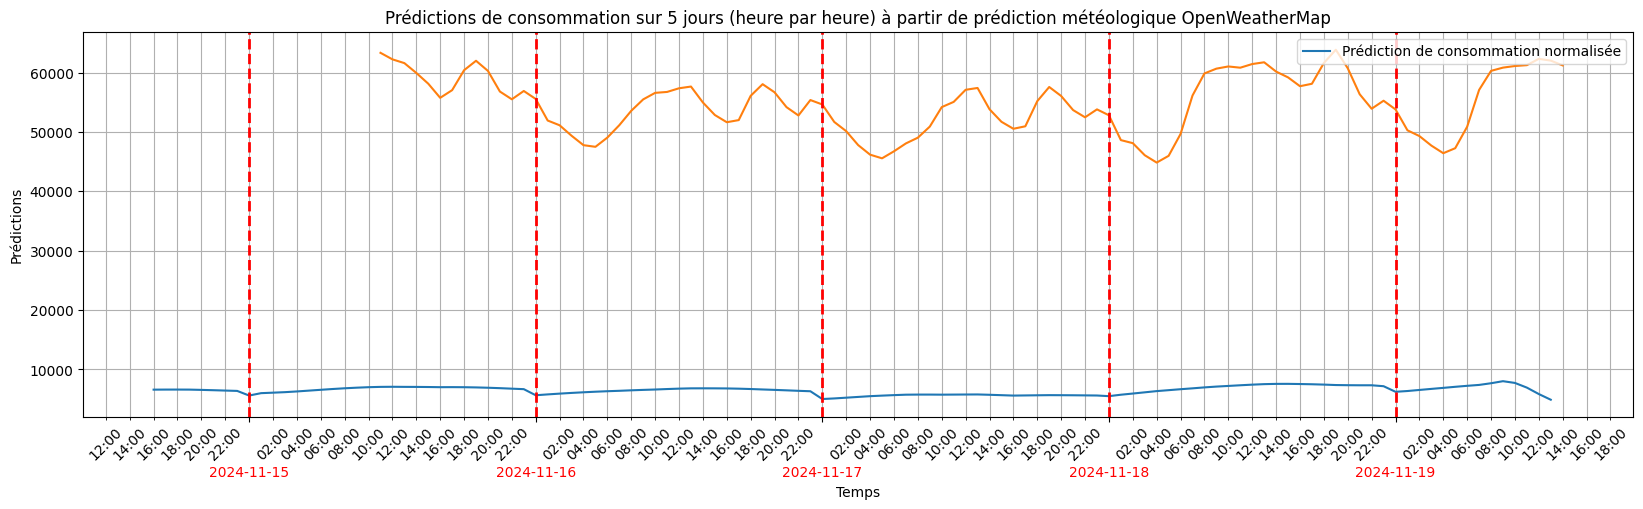

In [52]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Tracer le graphique
plt.figure(figsize=(20, 5))
plt.plot(data_raw['date'], prediction_denoised, label='Prédiction de consommation normalisée')  # Assurez-vous que 'predictions' correspond à la longueur de 'data_raw['date']'

plt.plot(data_reality['Date'],data_reality['Consommation (MW)'])

# Définir le format des dates
plt.xlabel('Temps')
plt.ylabel('Prédictions')
plt.title('Prédictions de consommation sur 5 jours (heure par heure) à partir de prédiction météologique OpenWeatherMap')

# Modifier les ticks de l'axe des x pour afficher toutes les 24 heures + heure toutes les 2h
plt.xticks(rotation=0)  # Ne pas incliner les labels des dates principales

# Définir les ticks principaux (tous les jours)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Un tick toutes les 24h
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format de la date

# Ajouter une deuxième ligne d'abscisse pour l'heure toutes les 2 heures
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=2))  # Ticks toutes les 2 heures
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # Format de l'heure

# Rotation des labels des heures mineures pour une meilleure lisibilité
plt.gca().tick_params(axis='x', which='minor', rotation=45)  # Rotation des labels des heures mineures

# Activer la grille pour les ticks mineurs (heures)
plt.grid(True, which='both')

# Ajouter des lignes de grille rouges et modifier les dates du début de jour
ax = plt.gca()
for date in data_raw['date']:
    if date.hour == 0 and date.minute == 0:  # Si c'est le début d'un nouveau jour
        # Ajouter une ligne verticale rouge
        ax.axvline(x=date, color='red', linestyle='--', lw=2)  # Ajouter une ligne verticale rouge

        # Mettre la date en rouge sur l'axe des x et décaler les dates en dessous
        tick_labels = ax.get_xticklabels()
        for label in tick_labels:
            if label.get_text() == date.strftime('%Y-%m-%d'):
                label.set_color('red')  # Mettre en rouge la date du début de jour
                label.set_position((label.get_position()[0], -0.10))  # Déplacer la date 10 points plus bas

# Ajouter la légende en haut à droite
plt.legend(loc='upper right')
title = plt.gca().get_title()
output_dir = "/Users/eliotsouthon/Desktop/POC/Images"
ma_bibliotheque.save_figure(title, output_dir)

plt.show()

Figure sauvegardée dans /Users/eliotsouthon/Desktop/POC/Images/default_image_name.png


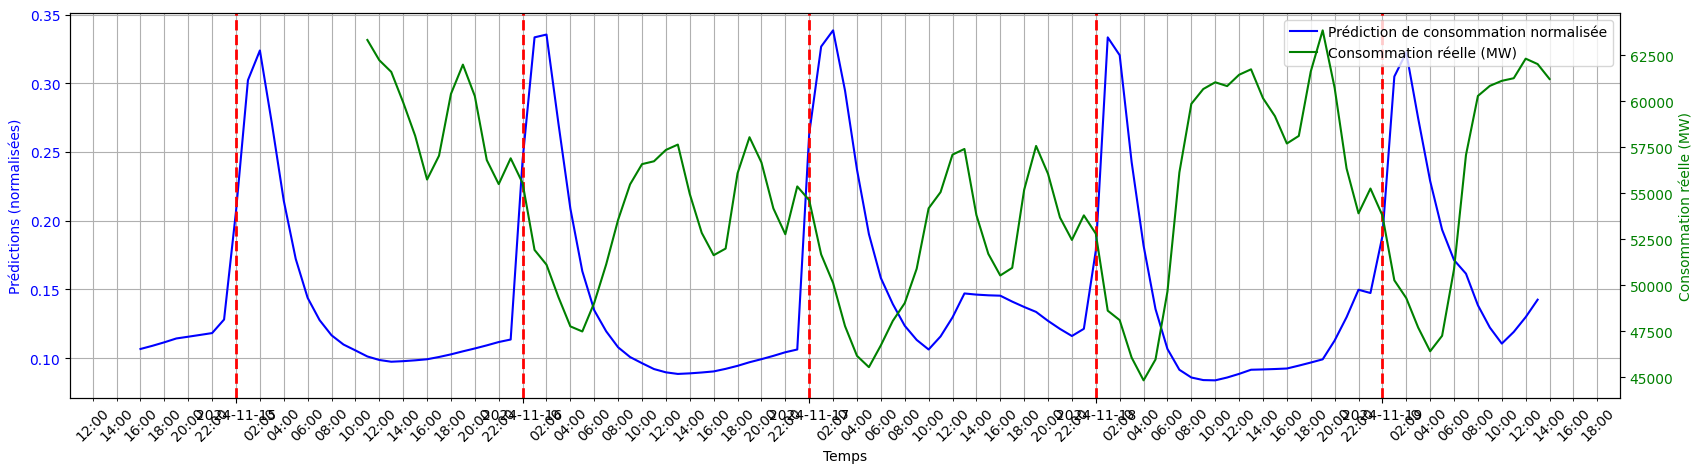

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Tracer le graphique
fig, ax1 = plt.subplots(figsize=(20, 5))

# Tracer la première courbe (prédictions) sur l'axe principal (gauche)
ax1.plot(data_raw['date'], predictions, label='Prédiction de consommation normalisée', color='blue')
ax1.set_xlabel('Temps')
ax1.set_ylabel('Prédictions (normalisées)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Ajouter la deuxième courbe sur un axe secondaire (droite)
ax2 = ax1.twinx()  # Crée un second axe des ordonnées
ax2.plot(data_reality['Date'], data_reality['Consommation (MW)'], label='Consommation réelle (MW)', color='green')
ax2.set_ylabel('Consommation réelle (MW)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Définir le format des dates pour l'axe des x
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Ticks principaux tous les jours
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format des dates principales
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=2))  # Ticks secondaires toutes les 2 heures
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # Format des heures secondaires

# Rotation des labels pour lisibilité
ax1.tick_params(axis='x', which='minor', rotation=45)  # Rotation des ticks mineurs
ax1.tick_params(axis='x', which='major', rotation=0)  # Pas de rotation pour les ticks majeurs

# Activer la grille
ax1.grid(True, which='both')

# Ajouter des lignes de grille rouges pour les débuts de journée
for date in data_raw['date']:
    if date.hour == 0 and date.minute == 0:  # Si c'est le début d'un nouveau jour
        ax1.axvline(x=date, color='red', linestyle='--', lw=2)  # Ligne verticale rouge

# Ajouter la légende combinée
lines1, labels1 = ax1.get_legend_handles_labels()  # Lignes/légendes du premier axe
lines2, labels2 = ax2.get_legend_handles_labels()  # Lignes/légendes du second axe
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')  # Combiner et placer en haut à droite

# Enregistrer l'image
title = ax1.get_title()
output_dir = "/Users/eliotsouthon/Desktop/POC/Images"
ma_bibliotheque.save_figure(title, output_dir)

# Afficher le graphique
plt.show()